## In this notebook: Figure 2F

In [5]:
import numpy as np
import pandas as pd

# import mido
import ast
import scipy
from scipy.stats import ttest_rel, wilcoxon
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statannotations.Annotator import Annotator

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("article.mplstyle")

import seaborn as sns

import glob
import os


### Preparing data

In [6]:
#      DIRECTORIES
######################

scores_dir = '../analysis_training/training_scores'
figs_dir = './figures'
files = sorted(glob.glob(os.path.join(scores_dir,'*.csv')))

df_scores = pd.DataFrame()

for file in files:
    df = pd.read_csv(file)
    df_scores = pd.concat([df_scores, df])


# DEFINING PARTICIPANTS
subjects = df_scores['subject'].unique()

In [7]:
def ave_score(score_df, period):
    means = []
    subjects = []
    musicianship = []
    for subject in df_scores['subject'].unique():
        # if subject in musicians:
        #     is_musician = 1
        # else: 
        #     is_musician = 0
        # musicianship.append(is_musician)
        if period == 'pre':
            mean_sub = np.mean(df_scores[(df_scores['subject'] == subject) & (df_scores['trial_number']<=82)]['score'])
        elif period == 'post':
            mean_sub = np.mean(df_scores[(df_scores['subject'] == subject) & (df_scores['trial_number']>=82)]['score'])
        elif period == 'beginning1': 
            mean_sub = np.mean(df_scores[(df_scores['subject'] == subject) & (df_scores['trial_number']<=10)]['score'])
        elif period == 'beginning2': 
            mean_sub = np.mean(df_scores[(df_scores['subject'] == subject) & (df_scores['trial_number']>82)& (df_scores['trial_number']<=92)]['score'])

        elif period == 'all':
            mean_sub = np.mean(df_scores[(df_scores['subject'] == subject)]['score'])
        else:
            print('Valid periods are pre, post, and all')
            
        means.append(mean_sub)
        subjects.append(subject)

    ave_df = pd.DataFrame({'subject': subjects, 
                           'score': means, 'period': period, 
                        #    'musician': musicianship
                           })

    return ave_df

### Overall scores over 2 blocks

In [8]:
means_pre = ave_score(df_scores, 'pre')
means_post = ave_score(df_scores, 'post')
means_overall = pd.concat([means_pre, means_post])

wilcoxon: stat = 32.0, p = 0.0024824142456054688
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: Custom statistical test, P_val:2.482e-03


/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

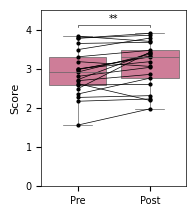

In [12]:


plt.figure(figsize=(2,2.2))

# Generate a colormap for unique subjects
ax =sns.boxplot(means_overall, x = 'period', y = 'score', color='palevioletred')

cmap = plt.get_cmap('tab20')  # Tab20 has a wide range of distinguishable colors
colors = cmap(np.linspace(0, 1, len(means_overall['subject'].unique())))

for idx, subject in enumerate(means_overall['subject'].unique()):
    means_sub_pre = means_overall[(means_overall['subject']==subject) & (means_overall['period']=='pre')]['score'].values
    means_sub_post = means_overall[(means_overall['subject']==subject) & (means_overall['period']=='post')]['score'].values
    
    # Add a line with markers for each subject
    plt.plot([0,1], [means_sub_pre, means_sub_post], 
             marker='o', linestyle='-', label=subject, color = 'black')
# Add x-axis labels for better clarity
plt.xticks([0,1], ['Pre', 'Post'])

# Perform Wilcoxon test
scores_pre = means_overall[means_overall['period'] == 'pre']['score'].values
scores_post = means_overall[means_overall['period'] == 'post']['score'].values
stat, p = wilcoxon(scores_pre, scores_post)
print(f'wilcoxon: stat = {stat}, p = {p}')

# Annotate significance
pairs = [("pre", "post")]
annotator = Annotator(ax, pairs, data=means_overall, x='period', y='score')
annotator.configure(test=None, text_format='star', loc='inside', 
                    fontsize = mpl.rcParams['xtick.labelsize'],
                    line_width = mpl.rcParams['lines.linewidth'],
                    )

annotator.set_pvalues([p])
annotator.annotate()

# Adjust legend to be outside of the plot
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Subjects")

# plt.title('Subject Scores Pre vs. Post')
plt.xlabel('')
plt.ylabel('Score')
plt.ylim(0, 4.5)
plt.yticks([0,1,2,3,4])

plt.tight_layout()
plt.savefig(figs_dir+'/train_score.svg')
